
# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

The objective of this experiment is to understand how to prune neurons in Neural Networks.


Throughout the course, we have been discussing big neural networks models with a huge amount of parameters. The concentration of the parameters is much more in the fully connected layers and this brings us to the question whether so many parameters in the FC Layers are necessary.

<img src='https://cdn.talentsprint.com/aiml/Experiment_related_data/week11/Exp2/pruning.jpg'>

While pruning connections of the network by making the weight space sparse, we were able to drop connections. However, the model occupied the same amount of size as before in memory while doing a forward pass. Thus we would not be able to exploit that procedure to its fullest unless we write separate modules for sparse matrix multiplications in neural networks which the deep learning libraries do not provide.

In this notebook we shall see one of the solutions which remove redundant neurons from the network. Our focus shall be on fully connected layers. Through this approach we can not only reduce the size of the network on disk but the resultant model as whole will occupy less space in the RAM during a forward pass.

#### Keywords

* li_regularizer
* lo_regularizer
* Pruning

#### Expected time to complete the experiment is : 90min

### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P19A06E_test" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "981234567" #@param {type:"string"}


In [3]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="BLR_M3W13_SAT_EXP_2" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torchvision")
    print ("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "id" : Id, "file_hash" : file_hash, "notebook" : notebook}

      r = requests.post(url, data = data)
      print("Your submission is successful.")
      print("Ref Id:", submission_id)
      print("Date of submission: ", datetime.datetime.now().date().strftime("%d %b %Y"))
      print("Time of submission: ", datetime.datetime.now().time().strftime("%H:%M:%S"))
      print("View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions")
      print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


In [0]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt

### Hyperparameters

In [0]:
num_epochs = 5
batch_size = 100
learning_rate = 0.001
use_reg = False
alpha = 0.5
beta = 1-alpha

### Downloading MNIST

In [0]:
train_dataset = dsets.MNIST(root='../data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../data/',
                           train=False, 
                           transform=transforms.ToTensor())

### Dataloader

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### Defining a fully connected network to classify MNIST

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(F.relu(out))
        out = self.fc3(F.relu(out))
        return out

<b>The below function is called to reinitialize the weights of the network and define the required loss criterion and the optimizer.</b> 

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def reset_model():
    net = Net()
    net = net.to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    return net,criterion,optimizer

### Network Initialization

In [0]:
net, criterion, optimizer = reset_model()

### Regularizers

The goal of introducing l1 regulariser and l2 regulariser is to penalise the connections' weights between neurons to prevent overfitting. However, the application of such regularisers alone in deep neural network are not as successful as in linear regression and logistic regression. On the other hand, in the hardware computation especially using GPU, dropping connections may not save computation time and memory unless some special coding and processing is used. The introduction of dropout achieve great success to avoid over-fitting in practice with these two regularisers. These regularisation techniques are suitable for preventing overfitting but may not be helpful in simplifying the NN structure. 

Here, we see two more regularizers which help is exploring the sparsity.

$$
li\_regularizer = \lambda_{l_{i}}\sum_{l=1}^{L}\sum_{j=1}^{n_{l}}\sqrt{\sum_{i=1}^{n_{l-1}}(W_{i,j}^{l})^{2}}
$$

$$
lo\_regularizer = \lambda_{l_{i}}\sum_{l=1}^{L}\sum_{i=1}^{n_{l-1}}\sqrt{\sum_{j=1}^{n_{l}}(W_{i,j}^{l})^{2}}
$$

$$
loss = loss + \alpha*li\_regularizer + (1-\alpha)*lo\_regularizer
$$

### LI Regularizer definition

In [0]:
def li_regularizer(net):
    
    lambda_li = 0.001
    li_reg_loss = 0
    for m in net.modules():
        if isinstance(m,nn.Linear):
            temp_loss = torch.sum(((torch.sum(((m.weight)**2),1))**0.5),0)
            li_reg_loss += lambda_li*temp_loss

    return li_reg_loss


### LO Regularizer definition

In [0]:
def lo_regularizer(net):
    
    lambda_lo = 0.001
    lo_reg_loss = 0
    for m in net.modules():
        if isinstance(m,nn.Linear):
            temp_loss = torch.sum(((torch.sum(((m.weight)**2),0))**0.5),-1)
            lo_reg_loss += lambda_lo*temp_loss
    
    return lo_reg_loss

### L1 Regularizer definition

In [0]:
def l1_regularizer(net, loss, beta):
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in net.parameters():
        target = (torch.FloatTensor(param.size()).zero_()).to(device)
        reg_loss += l1_crit(param, target)
        print(type(reg_loss))
        
    loss += beta * reg_loss
    return loss

### Training and Testing functions

In [0]:
# Train the Model

def training(net):
    
    net, criterion, optimizer = reset_model()
    
    net.train()
    for epoch in range(num_epochs):
        total_loss = 0
        accuracy = []
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            temp_labels = labels
            

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            
            if use_reg == True :
        
                loss = loss + alpha*li_regularizer(net) + beta*lo_regularizer(net)
                
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == temp_labels).sum().item()
            accuracy.append(correct/float(batch_size))

        print('Epoch: %d, Loss: %.4f, Accuracy: %.4f' %(epoch+1,total_loss, (sum(accuracy)/float(len(accuracy)))))
    
    return net

In [0]:
# Test the Model
def testing(net):
    net.eval() 
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the network on the 10000 test images: %.2f %%' % (100.0 * correct / total))

In [18]:
use_reg = False
net = training(net)
testing(net)

Epoch: 1, Loss: 118.5065, Accuracy: 0.9411
Epoch: 2, Loss: 46.6769, Accuracy: 0.9757
Epoch: 3, Loss: 30.6087, Accuracy: 0.9838
Epoch: 4, Loss: 22.1309, Accuracy: 0.9884
Epoch: 5, Loss: 18.7918, Accuracy: 0.9895
Test Accuracy of the network on the 10000 test images: 97.96 %


### Visualizing the weight Space

In [0]:
def weightdistribution(weights):
    maxim= np.amax(weights)
    print("Maximum value of learnt weights: " + str(maxim))
    
    minim= np.amin(weights)
    print("Minimum value of learnt weights: " + str(minim))
    
    step= (maxim-minim)/255
    freq= np.zeros(256)
    steps=[]

    for i in range(0,256):
        steps.append(minim)
        minim+=step
    
    m = weights.shape[0]
    
    for i in range(0,m):
        e= weights[i]
        dist= (steps-e)**2
        freq[np.argmin(dist)]+=1
    
        
    plt.plot(steps,list(freq))
    plt.show()

Maximum value of learnt weights: 0.25172827
Minimum value of learnt weights: -0.39371997


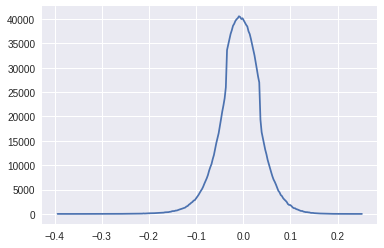

Maximum value of learnt weights: 0.38436747
Minimum value of learnt weights: -0.3454456


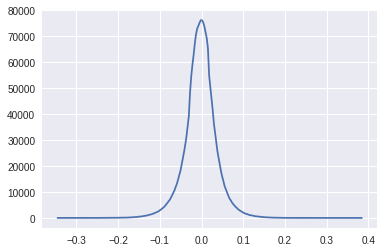

Maximum value of learnt weights: 0.14318238
Minimum value of learnt weights: -0.3736624


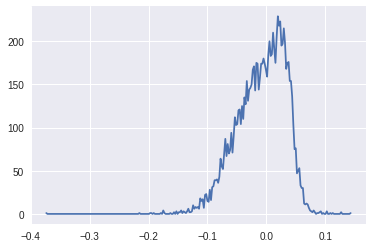

In [21]:
weightdistribution(net.state_dict()['fc1.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc2.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc3.weight'].cpu().numpy().flatten())

### Training with the defined regularizers

Next we train with the li and lo regularizers defined previously. We hope to address the issue of overfitting to some extent by using these regularizers. Also, the weight matrices are plotted to observe the distribution. 

In [22]:
use_reg = True
net = training(net)
testing(net)

Epoch: 1, Loss: 531.4852, Accuracy: 0.9201
Epoch: 2, Loss: 276.0505, Accuracy: 0.9581
Epoch: 3, Loss: 231.2043, Accuracy: 0.9669
Epoch: 4, Loss: 211.2735, Accuracy: 0.9697
Epoch: 5, Loss: 195.9977, Accuracy: 0.9724
Test Accuracy of the network on the 10000 test images: 97.41 %


Maximum value of learnt weights: 0.21165426
Minimum value of learnt weights: -0.37144402


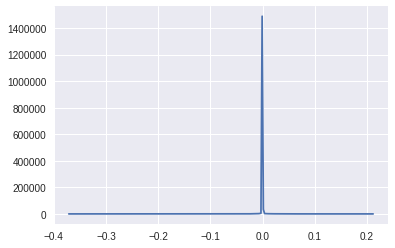

Maximum value of learnt weights: 0.34271562
Minimum value of learnt weights: -0.24282782


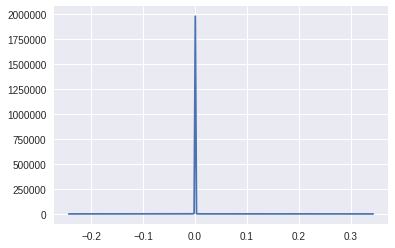

Maximum value of learnt weights: 0.33154362
Minimum value of learnt weights: -0.44787857


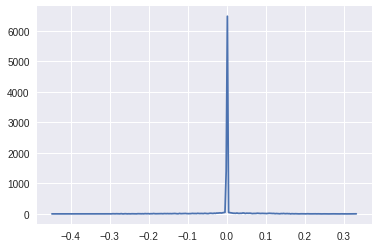

In [23]:
weightdistribution(net.state_dict()['fc1.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc2.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc3.weight'].cpu().numpy().flatten())

### Pruning

We next prune the parameters based ona threshold criterion as seen previously. The parameters before and after pruning are printed below.

In [0]:
threshold = 0.01

for m in net.modules():
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.BatchNorm2d) or isinstance(m,nn.Linear):
        
        temp_weight = m.weight.data.cpu().numpy()
        dims = temp_weight.shape
        print('WEIGHT ',dims)
        print("Before pruning------->")
        print(np.count_nonzero(temp_weight))
        
        temp_weight = temp_weight.flatten()
        
        [x1,x2]=((np.where(np.all([[(-1*threshold) < (temp_weight)] , [(temp_weight) < threshold]],axis=0))))
        temp_weight[x2] = 0
        temp_weight = np.reshape(temp_weight,dims)
        print("After pruning------->")
        print(np.count_nonzero(temp_weight))
        print('-------------------------------------------------------------------------------')
        m.weight.data = (torch.FloatTensor(temp_weight).to(device))

### Removing all zero rows and columns

1. We remove those columns in the weight matrices which have all the values as zero.
2. In the weight matrix for the next layer, we need to remove the corresponding rows.
3. We must eventually end up removing the intersection of the two.

<img src='https://cdn.talentsprint.com/aiml/Experiment_related_data/week11/Exp2/drop_neuron.png'>

In [24]:
fc1_weight = net.fc1.weight.data.cpu().numpy()
fc2_weight = net.fc2.weight.data.cpu().numpy()
fc3_weight = net.fc3.weight.data.cpu().numpy()

print('---------------------------Original dimensions-----------------------')
print(fc1_weight.shape)
print(fc2_weight.shape)
print(fc3_weight.shape)
print('---------------------------Final dimensions-----------------------')

fc1_row_zero = np.where(~fc1_weight.any(axis=1))[0]
fc2_col_zero = np.where(~fc2_weight.any(axis=0))[0]
indices = set(fc1_row_zero).intersection(fc2_col_zero)
indices = list(indices)

fc1_weight = np.delete(fc1_weight,indices,axis=0)
fc2_weight = np.delete(fc2_weight,indices,axis=1)


fc2_row_zero = np.where(~fc2_weight.any(axis=1))[0]
fc3_col_zero = np.where(~fc3_weight.any(axis=0))[0]
indices = set(fc2_row_zero).intersection(fc3_col_zero)
indices = list(indices)

fc2_weight = np.delete(fc2_weight,indices,axis=0)
fc3_weight = np.delete(fc3_weight,indices,axis=1)

print(fc1_weight.shape)
print(fc2_weight.shape)
print(fc3_weight.shape)

---------------------------Original dimensions-----------------------
(2000, 784)
(1000, 2000)
(10, 1000)
---------------------------Final dimensions-----------------------
(2000, 784)
(1000, 2000)
(10, 1000)


### Define a Modified Network

After removing entire rows and columns of the bigger weight matrices we are left with smaller number of parameters which we can use to initialize a smaller network. In order to do that, first we need to define one.

We define a modified network by using the dimensions of the modified weight matrix which we received in our previous step. Then, we reset that model too.

In [0]:
class Mod_Net(nn.Module):
    def __init__(self):
        super(Mod_Net, self).__init__()
        self.fc1 = nn.Linear(fc1_weight.shape[1], fc1_weight.shape[0])
        self.fc2 = nn.Linear(fc2_weight.shape[1], fc2_weight.shape[0])
        self.fc3 = nn.Linear(fc3_weight.shape[1], fc3_weight.shape[0])
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(F.relu(out))
        out = self.fc3(F.relu(out))
        return out

In [0]:
def reset_mod_model():
    modnet = Mod_Net()
    modnet = modnet.cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modnet.parameters(), lr=learning_rate)
    return modnet,criterion,optimizer

In [0]:
modnet, criterion, optimizer = reset_mod_model()

Here we initialize the smaller model with the smaller weight matrices. 

In [0]:
modnet.fc1.weight.data = (torch.FloatTensor(fc1_weight).to(device))
modnet.fc2.weight.data = (torch.FloatTensor(fc2_weight).to(device))
modnet.fc3.weight.data = (torch.FloatTensor(fc3_weight).to(device))

In [29]:
testing(modnet)

Test Accuracy of the network on the 10000 test images: 96.77 %


### Excercise

1. Retrain the smaller model and check if the performance improves.

2. Using the l1 regularizer along with lo and li with further enhance sparsity. This might result in a even smaller model. Try it out!!

### References

1. https://arxiv.org/pdf/1606.07326.pdf

### Please answer the questions below to complete the experiment:

In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "" #@param ["Yes", "No"]

In [0]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")